# JPMaQS with Statsmodels

This notebook showcases the application of the widely-used `statsmodels` library in Python for conducting statistical analyses on JPMaQS data. We provide practical code examples and additional references for further reading.

# Imports

Largely, only the standard packages in the Python data science stack are required to run this notebook. The specialized `macrosynergy` package is also needed to download JPMaQS data and for quick analysis of quantamental data and value propositions. We also use some functions from the `macrosynergy` package to simplify the code.

In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
print(str(Path.cwd().parent))

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

import statsmodels.api as sm
import statsmodels.graphics.api as smg
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.regression.rolling import RollingOLS
from statsmodels.api import add_constant
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smt
import statsmodels.graphics.tsaplots as tsap


import warnings

warnings.simplefilter("ignore")

import kagglehub
import os
#os.environ['KAGGLEHUB_CACHE'] = './kaggle'
#macrosynergy_fixed_income_returns_and_macro_trends_path = kagglehub.dataset_download('macrosynergy/fixed-income-returns-and-macro-trends')
macrosynergy_fixed_income_returns_and_macro_trends_path = './kaggle'

print('Data source import complete.')
print('Data source path:', macrosynergy_fixed_income_returns_and_macro_trends_path)
df = pd.read_csv(macrosynergy_fixed_income_returns_and_macro_trends_path + '\JPMaQS_Quantamental_Indicators.csv', index_col=0, parse_dates=['real_date'])
display (df.head(3))
df.info()
start_date = df['real_date'].min()
print(start_date)


c:\finance\macrosynergy
Data source import complete.
Data source path: ./kaggle


,real_date,cid,xcat,value,grading,eop_lag,mop_lag
0,2000-01-03,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,95.0,292.0
1,2000-01-04,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,96.0,293.0
2,2000-01-05,AUD,CPIC_SA_P1M1ML12,1.244168,2.0,97.0,294.0


<class 'pandas.core.frame.DataFrame'>
Index: 3390059 entries, 0 to 3390058
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   real_date  datetime64[ns]
 1   cid        object        
 2   xcat       object        
 3   value      float64       
 4   grading    float64       
 5   eop_lag    float64       
 6   mop_lag    float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 206.9+ MB
2000-01-03 00:00:00


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

* `value` giving the latest available values for the indicator
* `eop_lag` referring to days elapsed since the end of the observation period
* `mop_lag` referring to the number of days elapsed since the mean observation period
* `grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md) or use the free dataset on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends)



In [78]:
# Cross-sections of interest

cids_dm = ["AUD", "CAD", "CHF", "EUR", "GBP", "JPY", "NOK", "NZD", "SEK", "USD"]
cids_em = [
    "CLP",
    "COP",
    "CZK",
    "HUF",
    "IDR",
    "ILS",
    "INR",
    "KRW",
    "MXN",
    "PLN",
    "THB",
    "TRY",
    "TWD",
    "ZAR",
]
cids = cids_dm + cids_em
cids_du = cids_dm + cids_em
cids_dux = list(set(cids_du) - set(["IDR", "NZD"]))
cids_xg2 = list(set(cids_dux) - set(["EUR", "USD"]))

In [79]:
# Quantamental categories of interest

main = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INTRGDPv5Y_NSA_P1M1ML12_3MMA",
    "PCREDITGDP_SJA_D1M1ML12",
    "RGDP_SA_P1Q1QL4_20QMA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]
econ = ["FXTARGETED_NSA", "FXUNTRADABLE_NSA"]  # economic context
rets = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
    "EQXR_NSA",
    "EQXR_VT10",
    "FXXR_NSA",
    "FXXR_VT10",
]

xcats = main + econ + rets
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]

The description of each JPMaQS category is available either under [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected, full set of 5000+ indicators) or on [Kaggle](https://www.kaggle.com/datasets/macrosynergy/fixed-income-returns-and-macro-trends) (just for the tickers used in this notebook, no password required).

To ensure reproducibility, only samples between January 2000 (inclusive) and May 2023 (exclusive) are considered.

The `JPMaQSDownload.download()` method returns requested indicators in a standard `pandas` dataframe, above denoted by `df`. Most JPMaQS data is provided in panel format. This means that for a given requested indicator category (`df.xcat`), the dataframe comprises a time component (`df.real_date`) and a cross-sectional component (`df.cid`). The cross-sections are the requested currency areas for the indicator category.

This example notebook contains a few select categories for a subset of developed and emerging markets: AUD (Australian dollar), CAD (Canadian dollar), CHF (Swiss franc), CLP (Chilean peso), COP (Colombian peso), CZK (Czech Republic koruna), EUR (euro), GBP (British pound), HUF (Hungarian forint), IDR (Indonesian rupiah), ILS (Israeli shekel), INR (Indian rupee), JPY (Japanese yen), KRW (Korean won), MXN (Mexican peso), NOK (Norwegian krone), NZD (New Zealand dollar), PLN (Polish zloty), SEK (Swedish krona), TRY (Turkish lira), TWD (Taiwanese dollar), USD (U.S. dollar) and ZAR (South African rand).  

In [80]:
display(df['xcat'].unique())
display(df['cid'].unique())
df['ticker'] = df['cid'] + "_" + df["xcat"]
#df.head(3)

array(['CPIC_SA_P1M1ML12', 'CPIC_SJA_P3M3ML3AR', 'CPIC_SJA_P6M6ML6AR',
       'CPIH_SA_P1M1ML12', 'CPIH_SJA_P3M3ML3AR', 'CPIH_SJA_P6M6ML6AR',
       'DU02YXR_NSA', 'DU02YXR_VT10', 'DU05YXR_NSA', 'DU05YXR_VT10',
       'EQXR_NSA', 'EQXR_VT10', 'FXCRR_NSA', 'FXTARGETED_NSA',
       'FXUNTRADABLE_NSA', 'FXXR_NSA', 'FXXR_VT10', 'INFTEFF_NSA',
       'INTRGDP_NSA_P1M1ML12_3MMA', 'INTRGDPv5Y_NSA_P1M1ML12_3MMA',
       'PCREDITBN_SJA_P1M1ML12', 'PCREDITGDP_SJA_D1M1ML12',
       'RGDP_SA_P1Q1QL4_20QMA', 'RYLDIRS02Y_NSA', 'RYLDIRS05Y_NSA'],
      dtype=object)

array(['AUD', 'CAD', 'CHF', 'CLP', 'COP', 'CZK', 'EUR', 'GBP', 'HUF',
       'IDR', 'ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'PLN',
       'SEK', 'THB', 'TRY', 'TWD', 'USD', 'ZAR'], dtype=object)

# A few words on the Statsmodels package

`Statsmodels` is the mainstream package for econometrics and statistical inference in Python. Its classes and functions support statistical estimation, tests, and data exploration. Over the last few years, Statsmodels development has been geared towards building correct and tested implementations of the standard suite of econometric models available in other statistical computing environments, such as R. The package is built on top of `NumPy`, `SciPy`, and `Pandas`.
Some helpful links are:

* __Official intro__: https://www.statsmodels.org/stable/index.html 
* __Articles on TorwardsDataScience__: https://towardsdatascience.com/tagged/statsmodels
* __Video introduction__: https://www.youtube.com/watch?v=2BdfjqyWj3c and https://www.youtube.com/watch?v=2DZGeKjEZgk
* __Linear regressions with Statsmodels video__: https://www.youtube.com/watch?v=uwPWuTN7b1I


# Regression with quantamental indicators

In this notebook, we focus on regression analysis for only a single cross-section (the United States). Analysis across multiple currency areas is covered in a separate notebook on [panel regression](https://www.kaggle.com/code/macrosynergy/panel-regression-with-jpmaqs).

## Preparation: downsampling and feature lagging 

JPMaQS indicators are daily (end-of-day) information states of the market on relevant economic developments and selected market indicators. Since economic information does not often change daily, it is more appropriate to perform regression analysis at lower frequencies, for instance at weekly, monthly, or quarterly intervals. Additionally, a useful feature transformation is downsampling to the lower-frequency end-of-period information state and, indeed, the return (target/label) to the lower-frequency period's sum (for non-compounded derivative returns).

Additionally, it is common to lag the features by a single period to assess their predictive power. This means that the feature values at a given period $t$ are paired with the respective return at period $t+1$.

In the example below, a list of basic macroeconomic trends is downsampled from daily to quarterly frequencies by selecting the last available value. The list of returns is downsampled by calculating the sum over the lower-frequency period. In addition, the feature is lagged by a single quarter.

For more detail on basic data manipulation with JPMaQS, see the example notebook on Kaggle [here](https://www.kaggle.com/code/macrosynergy/checkout-jpmaqs).

**First step**: Create dataframes of feature-relevant information and returns, i.e. filter out categories, cross-sections, and dates. The `reduce_df()` method in `macrosynergy.management` takes a dataframe, a list of categories, and a list of currency areas as input and returns the 'filtered' dataframe.

In [81]:
# Prepare for filtering

cids = ["USD"]  # only one cross-section

for_feats = [
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "RGDP_SA_P1Q1QL4_20QMA",
    "CPIC_SJA_P6M6ML6AR",
    "INFTEFF_NSA",
    "PCREDITBN_SJA_P1M1ML12",
]  # categories (building blocks) for feature calculation

targs = [
    "DU02YXR_NSA",
    "DU05YXR_NSA",
    "DU02YXR_VT10",
    "DU05YXR_VT10",
]  # target returns


# Filters

dfx_feats = msm.reduce_df(df, for_feats, cids, start=start_date)
dfx_target = msm.reduce_df(df, targs, cids, start=start_date)
print(dfx_feats.head())
print(dfx_target.head())

         real_date  cid                xcat     value  grading  eop_lag  \
3123842 2000-01-03  USD  CPIC_SJA_P6M6ML6AR  1.339167      2.0     34.0   
3123843 2000-01-04  USD  CPIC_SJA_P6M6ML6AR  1.339167      2.0     35.0   
3123844 2000-01-05  USD  CPIC_SJA_P6M6ML6AR  1.339167      2.0     36.0   
3123845 2000-01-06  USD  CPIC_SJA_P6M6ML6AR  1.339167      2.0     37.0   
3123846 2000-01-07  USD  CPIC_SJA_P6M6ML6AR  1.339167      2.0     38.0   

         mop_lag                  ticker  
3123842    216.0  USD_CPIC_SJA_P6M6ML6AR  
3123843    217.0  USD_CPIC_SJA_P6M6ML6AR  
3123844    218.0  USD_CPIC_SJA_P6M6ML6AR  
3123845    219.0  USD_CPIC_SJA_P6M6ML6AR  
3123846    220.0  USD_CPIC_SJA_P6M6ML6AR  
         real_date  cid         xcat     value  grading  eop_lag  mop_lag  \
3148834 2000-01-03  USD  DU02YXR_NSA -0.175947      1.0      0.0      0.0   
3148835 2000-01-04  USD  DU02YXR_NSA  0.078487      1.0      0.0      0.0   
3148836 2000-01-05  USD  DU02YXR_NSA -0.097281      1.0     

**Second step**: Engineer new features based on available series. JPMaQS categories are building blocks for professional investment factors and trading signals. Since JPMaQS data are standardized across markets, these transformations are easy and intuitive.  Here, we transform only for a single cross-section, but the code would look the same for multiple countries, except that `cids` would be a list of cross-sectional identifiers. 

We calculate excess growth, core inflation, and private credit dynamics. The `panel_calculator()` method from `macrosynergy.panel`, used in the cell below, makes the engineering of new features through mathematical operations very simple and intuitive.

In [82]:
# Calculate excess economic trends versus natural benchmarks

calcs = [
    "XINTRGDP_NSA_P1M1ML12_3MMA = INTRGDP_NSA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMA ",
    "XCPIC_SJA_P6M6ML6AR = CPIC_SJA_P6M6ML6AR - INFTEFF_NSA ",
    "XPCREDITBN_SJA_P1M1ML12 = PCREDITBN_SJA_P1M1ML12 - ( INFTEFF_NSA + RGDP_SA_P1Q1QL4_20QMA ) ",
]

dfx_feats = msp.panel_calculator(dfx_feats, calcs=calcs, cids=cids)

__Third step__: Reformat features and returns to "wide" time series dataframes. This means that the dataframes are indexed by the observation date, and columns relate to indicator categories. Features are subsequently downsampled and lagged, whilst targets are simply downsampled (summed) to a quarterly frequency. 


In [83]:
# Lagged quarterly features frame

dfw_feats = dfx_feats.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_feats = dfw_feats.resample("Q").last().reset_index().shift().dropna()
dfw_feats.set_index("real_date", inplace=True)

# Quarterly targets frame

dfw_targs = dfx_target.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_targs = dfw_targs.resample("Q").sum().reset_index()
dfw_targs.set_index("real_date", inplace=True)

See the first five samples for both the features and labels dataframes below.

In [84]:
display(dfw_feats.head())
display(dfw_targs.head())

xcat,XCPIC_SJA_P6M6ML6AR,XINTRGDP_NSA_P1M1ML12_3MMA,XPCREDITBN_SJA_P1M1ML12
real_date,,,
2000-03-31,-0.184430,1.261230,1.664372
2000-06-30,-0.022593,1.184691,4.571227
2000-09-30,-0.185416,1.025924,7.213148
2000-12-31,-0.591601,0.411317,5.705107
2001-03-31,-0.521001,-2.066184,4.130448


xcat,DU02YXR_NSA,DU02YXR_VT10,DU05YXR_NSA,DU05YXR_VT10
real_date,,,,
2000-03-31,-0.427090,-4.543782,-0.524028,-3.538019
2000-06-30,0.092793,0.656227,0.268634,0.029133
2000-09-30,1.003043,8.516633,1.959298,6.086803
2000-12-31,1.511263,15.513361,3.256757,13.271835
2001-03-31,1.919477,11.261416,2.481535,5.742377


## OLS linear regression

Ordinary least squares (OLS) regression estimates intercept and slope coefficients of a linear model for a continuous, real-valued dependent variable, as a function of one or more explanatory variables. This is done by minimizing the sum of squared differences in the training set predictions and labels, often referred to as the 'residual sum of squares'. OLS regression is based on a [set of assumptions](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/) on the true, underlying, relations between the variables.

There are two major applications of OLS in quantamental research with JPMaQS:
1. Analysis of a **linear **relationship** between two features** in order to adjust one feature (explanatory variable) for the impact of the other. For example, real interest rates that are not explained by common economic factors, such as growth and inflation can be adjusted to give excess real interest rates that point to trading opportunities.
2. Analysis of a **linear relation between past features and current trading returns**. This is one of the most common ways to assess the predictive power of features.

A notable characteristic of return regressions is that the proportion of variance in future returns, which can be explained by regression on macro quantamental indicators, is often relatively small and tends to decrease as the frequency of observations increases. In other words, these indicators are generally not effective in predicting high-frequency returns.

The declining explanatory power of macro quantamental indicators with higher observation frequencies is a common finding in empirical research. This suggests that the relationships between macroeconomic variables and asset returns are more pronounced over longer time horizons, such as monthly or quarterly periods, compared to shorter time intervals, such as daily or intraday data.

There are several reasons for this stylized feature. First, macroeconomic variables are subject to measurement errors and revisions, which can attenuate their predictive power at higher frequencies. Second, financial markets are influenced by a wide range of factors, including microstructure dynamics, market sentiment, and short-term noise, which can overshadow the impact of macroeconomic variables in the short term. Finally, the information content of macroeconomic data may take time to be fully incorporated into market prices, leading to a lagged response of asset returns to macro indicators.

Therefore, when conducting return regressions using macro quantamental indicators, it is important to consider the appropriate frequency of observations that aligns with the time horizon of interest and captures the relevant economic relationships.

The code cell below demonstrates how to train a linear regression model in Statsmodels using the previously determined features and labels dataframes.

In [85]:
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # add intercept to regression model
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10"]

mod = sm.OLS(y, X)  # define model
res = mod.fit()  # fit model
print(res.summary())  # summary table

                            OLS Regression Results                            
Dep. Variable:           DU02YXR_VT10   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     4.968
Date:                Wed, 02 Apr 2025   Prob (F-statistic):            0.00308
Time:                        20:26:45   Log-Likelihood:                -313.12
No. Observations:                  95   AIC:                             634.2
Df Residuals:                      91   BIC:                             644.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
XCPIC_SJA_P6M6ML6AR 

The `summary()` method of a fitted OLS model returns a comprehensive summary. A general overview of the interpretation can be found [here](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a). The following pieces of information are of particular interest:

* *The top-right panel describes the in-sample goodness-of-fit of the linear regression model*. It does not inform on the generalization ability of the model to data unseen during the model fitting procedure. The **R-squared** is the 'coefficient of determination', the proportion of variation in the dependent variable that can be explained by regressing on the explanatory variable(s). A pitfall of this metric is that adding more explanatory variables to the regression naturally biases the **R-squared** towards its maximum value of one.  **Adjusted R-squared** penalizes model size in order to make linear models with different numbers of parameters comparable. **Prob (F-Statistic)** gives the p-value of the hypothesis test for the 'existence of regression'. This test has the null hypothesis that all explanatory variables have no effect on the dependent variable. Lastly, **AIC** (Akaike information criterion) and **BIC** (Bayesian information criterion) are used to compare the efficacy of models in the process of linear regression, using a penalty system for measuring multiple variables. These numbers are often used for the feature selection of variables.

* *The middle panel characterizes the direction and strength of the influence of all explanatory variables* and the intercept of the regression. Thus, the **t statistic** divides the coefficient estimate by the estimated standard error of that estimation. The larger that value, the greater the coefficient's significance. Unlike the actual coefficient, the t-statistic does not depend on the scale of the explanatory variable. Based on the t-statistic, the **P>|t|** value associated with a particular model parameter is the p-value of the hypothesis test with null hypothesis that the true value of that parameter is zero. Thus, a p-value of 0.004 for the model parameter associated with `XCPIC_SJA_P6M6ML6AR` means that (assuming the underlying linear model assumptions hold), one would reject the null hypothesis at both 5% and 1% significance. This means that there is statistical grounding for including this variable in the regression. 

* *The bottom panel is looking for abnormalities in the regression residuals*, which may provide hints that the model is incorrectly specified. Standard assumptions would call the residuals to be normally distributed, which would correspond to an **Omnibus** value of zero. **Prob(Omnibus)** gives the p-value of the hypothesis test with null hypothesis that the residuals are normally distributed. The **Jarque-Bera** and **Prob(JB)** are alternative metrics for that same purpose. In an ideal scenario, there should be little evidence to reject the null hypothesis in either test. **Skew** and **Kurtosis** provide hints on whether or not the error distribution is skewed or has fat tails, which in turn indicates a lack of normality. Finally, the **Durbin-Watson** statistic helps to assess whether or not regression residuals are autocorrelated. An overview of this statistic can be found [here](https://medium.com/@analyttica/durbin-watson-test-fde429f79203). A statistic near 2 (1.5-2.5) suggests that there is no autocorrelation, whilst values nearer to the boundaries of 0 or 4 point to positive or negative autocorrelation respectively. Autocorrelation can compromise model inference.

Thus, the above OLS model suggests that (excess) core inflation has had a significant influence on subsequent quarterly IRS receiver returns, whilst the impact of excess economic and credit growth has not been significant. The model would have explained about 12% of the return variation. There is little evidence of residual autocorrelation and there is not enough evidence, looking at the Jarque-Bera and Omnibus test results, to reject the assumption of error normality.

A wide range of additional diagnostics tests is provided in `statsmodels` beyond standard summary indicators. For more information, see [here](https://www.statsmodels.org/stable/diagnostic.html). The purpose of the hypothesis tests is to evaluate whether or not the linear model assumptions are satisfied by the trained model. They provide statistical evidence for rejecting the null hypothesis of the respective test, quantified as a probability.

For example, the rainbow test is used to examine the null hypothesis that the regression is correctly modeled as linear. The basic idea is to compare the linear fit of the middle fraction of the ordered explanatory variable data with the fit of the overall sample. We would hope for insufficient evidence to reject the null hypothesis, corresponding to a large p-value. The standard is to fail to reject the null hypothesis should the p-value be greater than 0.05, although this is an arbitrary threshold and careful consideration is needed depending on the context. Ultimately, a p-value marginally smaller than a set threshold should lead to further investigation before a rejection of the null hypothesis is made.

As an example, one would reject the assumption of linearity, based on the rainbow test, at 5% significance but not at the 1% level. Further evidence should be sought, possibly visual in nature, not only statistical.

In [86]:
print(" Rainbow test for correctly modelling linearity ")
print(" F test value is ", sm.stats.linear_rainbow(res)[0])
print(" p-value of the test is ", sm.stats.linear_rainbow(res)[1])

 Rainbow test for correctly modelling linearity 
 F test value is  1.7319074613917633
 p-value of the test is  0.03486100507540792


The caution that should be exhibited in rejecting null hypotheses when statistical evidence is marginal, as gauged by a p-value against, is important to help prevent making a __Type 1 error__, also known as a __false positive__. This just means that a null hypothesis was rejected when it was in fact true. This is particularly important when multiple tests are performed sequentially: the more tests that are performed sequentially, the smaller the chosen p-value threshold should be to reject the null hypotheses. [This link](https://multithreaded.stitchfix.com/blog/2015/10/15/multiple-hypothesis-testing/) is a good reference for the topic and describes the 'Bonferroni correction', a method to correct a p-value threshold to account for sequential testing.

Diagnostic plots can be created using `Statsmodels` and `Seaborn` to assess model specification. Full information on the plotting options within `Statsmodels` can be found [here](https://www.statsmodels.org/stable/graphics.html). For example, the `plot_regress_exog()` method within the `graphics` submodule plots regression results against one specific explanatory variable to investigate its influence.

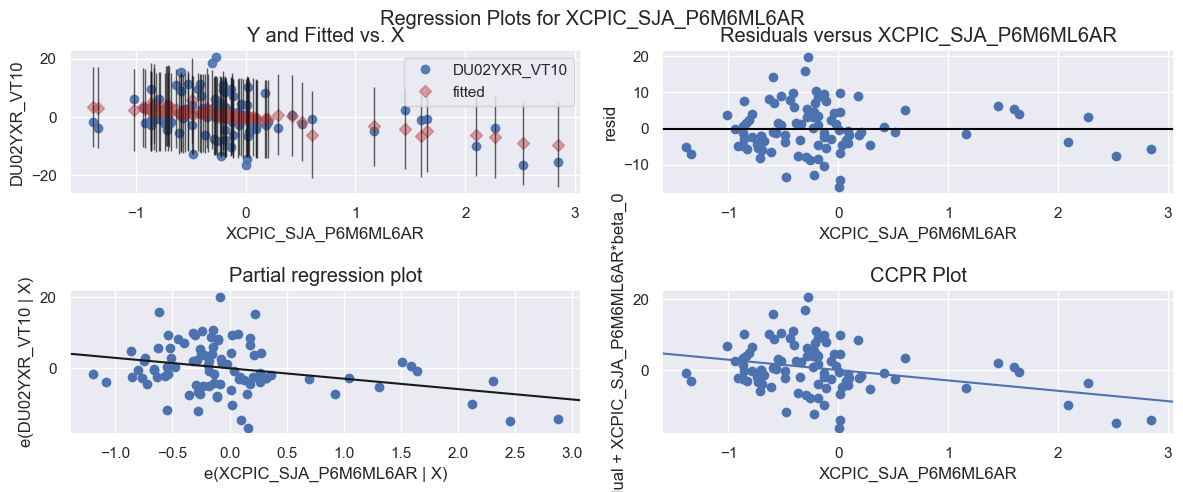

In [87]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(12, 5))
fig = sm.graphics.plot_regress_exog(res, "XCPIC_SJA_P6M6ML6AR", fig=fig)

All charts in the above panel inform on the explanatory power of a given explanatory variable in multiple linear regression.

* *The top left plot is a 'fit plot', showing both fitted values and ground truth labels against their respective explanatory variable values*. Superimposed on each fitted value is a 95% confidence interval. Ideally, all labels should lie within the respective 95% confidence interval.
* *The top right plot is a plot of model residuals against the explanatory variable*. Ideally, the plot should show no correlation or patterns and should be centered around the zero residual line. Indeed, this plot is often used to check the zero mean assumption for the model errors.
* *The bottom left plot is a 'partial regression plot', also known as an 'added variable plot'*. These should be favored over standard scatter plots in any multivariate setting because it shows the relationship between the dependent variable and the concerned explanatory variable, conditioned on the other independent variables in the regression, as opposed to marginalizing their effects out. Specifically, it is a plot of the residuals of the regression excluding the concerned explanatory variable (y-axis) against the residuals for the model regressing this explanatory variable against the other explanatory variables in the regression (x-axis).
* *The bottom right plot is a 'component-component plus residual plot'*. This is an alternative to the added variable plot and plots the residuals for the model that regresses the dependent variable against all explanatory variables except the concerned variable (y-axis), against the explanatory variable itself (x-axis).

The above plots indicate that there is a group of samples at the right of each plot, likely influential in the regression, that should be investigated further. These may be related to the results of the previous rainbow test.

The assumption of error normality can be visually assessed by creating a Q-Q plot, provided by `statsmodels` through the `qqplot` method. This plot compares the quantiles of the model residuals against the quantiles of a standard normal distribution. The plotted points should lie along a 45-degree straight line, with some leeway in the tails of the distribution. The Q-Q plot displayed below indicates that the assumption of error normality is valid.

Additionally, a check for autocorrelation of residuals can be performed. Autocorrelation measures the correlation between lagged values of a time series. By examining the autocorrelation of residuals, we can determine if there is any remaining pattern or correlation in the residuals that the model has not captured. If there is no significant autocorrelation detected, it provides evidence for the model errors being independent and not exhibiting systematic patterns. The below autocorrelation plot combined with the earlier inference based on the Durbin-Watson statistic suggests that it is sufficient to assume that there is no substantial autocorrelation in the residuals. 

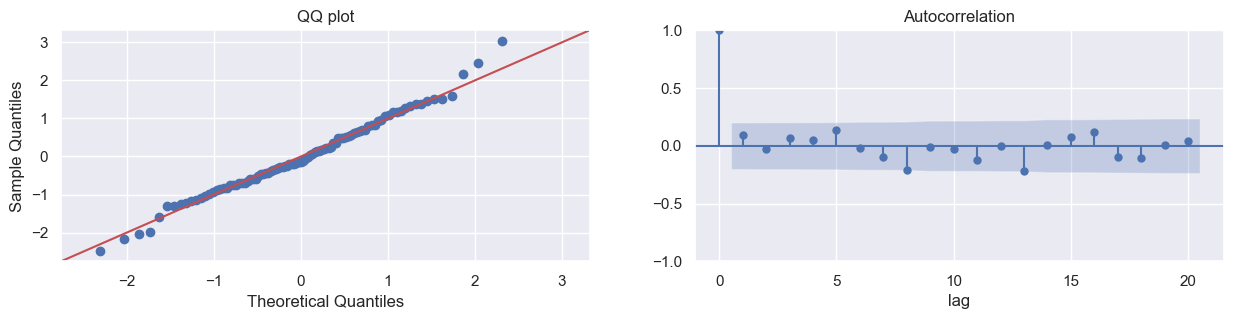

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.set(rc={"figure.figsize": (14, 5)})

sm.qqplot(data=res.resid, line="45", fit=True, ax=ax1)
ax1.set_title("QQ plot")


tsap.plot_acf(x=res.resid, ax=ax2)
ax2.set_xlabel("lag")
plt.show()

## Quantile regression

Outliers can have a substantial influence on the fit of an OLS linear regression model. They are particularly important to deal with in the context of financial markets research because market returns and quantamental indicators both have a proclivity to extreme values, for example in times of market dislocations and economic crises. Whilst various diagnostic tests are available to detect and subsequently remove outlying samples (see [here](https://www.statisticshowto.com/cooks-distance/) for more information), one way of deweighting these samples is through __quantile regression__. 

Ordinary least squares implicitly model the means of the target distributions (conditioned on the explanatory variables) as linear functions of the explanatory variables. Quantile regressions, in comparison, model an arbitrary quantile of the conditional distributions, the parametric form of whom are unknown, as linear in the explanatory variable realizations. The ability to model different quantiles is particularly useful in financial return predictions, as it allows us to examine whether an explanatory variable plays a similar role in explaining extreme returns compared to mid-range returns. The median (50%) quantile regression: 

* reduces the influence of outliers, by nature of estimating the median
* is more robust to a non-normal target distribution than ordinary least squares
* allows for heterogeneous relationships between independent and dependent variables.

The `statsmodels` implementation of quantile regression is based on ["Quantile Regression" by R Koenker and K Hallock](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.15.4.143) 

Below, we use quantile regression to explain monthly 2-year IRS receiver returns with the end-of-last month's inflation trend in the U.S. We apply the common case of median (50% quantile) estimation, i.e. `q=0.5`. This is also called *Least Absolute Deviation (LAV)*. 

In [89]:
dfw = pd.merge(dfw_feats, dfw_targs, left_index=True, right_index=True)
mod = smf.quantreg(
    "DU02YXR_VT10 ~ XCPIC_SJA_P6M6ML6AR + XINTRGDP_NSA_P1M1ML12_3MMA + XPCREDITBN_SJA_P1M1ML12",
    dfw,
)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:           DU02YXR_VT10   Pseudo R-squared:              0.04616
Model:                       QuantReg   Bandwidth:                       6.589
Method:                 Least Squares   Sparsity:                        17.25
Date:                Wed, 02 Apr 2025   No. Observations:                   95
Time:                        20:26:46   Df Residuals:                       91
                                        Df Model:                            3
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0525      0.942      0.056      0.956      -1.818       1.923
XCPIC_SJA_P6M6ML6AR           -3.2627      1.222     -2.671      0.009      -5.689      -0.836
XINTRGDP_NSA_P1M1ML12_3MMA     0.0198      0.377      0.052      0.

**Pseudo R-squared**, proposed by [R Koenker and J Machado](https://www.maths.usyd.edu.au/u/jchan/GLM/Koenker&Machado1999InferenceQuantileReg.pdf), is a measure of goodness-of-fit for quantile regression models and is the analog of **R-squared** for this class of models. It works by comparing, for a given quantile, an appropriately weighted sum of deviations/residuals for the null model (comprising only an intercept) with the full model. Like R-squared, it has a maximum value of 1. As opposed to being a global measure of goodness of fit, it measures local goodness of fit for a particular quantile.

The __bandwidth__ is a hyperparameter set to help estimate the asymptotic covariance matrix of the quantile regression estimator, which is needed to compute the standard errors and subsequent t-values in the regression summary. This asymptotic covariance matrix is dependent on knowing the density of the true error distribution at zero, but since quantile regression places no distributional assumptions on the model errors/disturbances, a kernel density estimation (KDE) of the residuals is performed under-the-hood. The bandwidth gauges the granularity of the resulting KDE and is defined through a rule of thumb. For advanced details, see page 448 of Greene's [Econometrics](http://www.mim.ac.mw/books/William%20H.%20Green's%20Econometric.pdf) textbook. The __sparsity__ is the inverse of the estimated density of the residuals at zero (from the KDE).

Since the covariance matrix of the quantile regression estimator is known only asymptotically and no distributional assumptions are imposed, the t-test results should be interpreted with caution and complemented with additional diagnostic tests and sensitivity analyses. 

The plots below provide an illustration of the differences between quantile regression and ordinary least squares (OLS) regression in capturing non-linear and heterogeneous relationships.

The left-hand plot displays the best-fit lines for 10 different quantile regression models, together with the OLS fitted line for regressing subsequent 2-year interest rate swap returns on excess core CPI trends. Quantile regression allows for capturing varying slopes and intercepts at different quantiles, providing a more flexible modeling approach compared to the single-line fit of OLS regression. This is particularly useful when the relationship between the variables exhibits heterogeneity across different parts of the conditional distribution. The plot highlights that quantile regression lines can deviate from the OLS line, indicating non-linear patterns and variations in the relationship between the variables across different quantiles. 

The right-hand plot displays the slope coefficients of the quantile regressions for different quantiles of the target returns, along with their 95% confidence intervals. The plot also includes the corresponding values for the OLS regression. It shows that for lower and mid-range returns, the quantile regression coefficients are negative and close to the OLS estimate. However, the plot reveals an interesting pattern for very high quantile returns. The slope coefficients for these extreme quantiles become positive, suggesting a positive relationship between inflation and IRS returns in the extreme range. This finding indicates a different pattern or behavior in the tails of the return distribution compared to the rest of the distribution.

In [90]:
quantiles = np.arange(0.05, 0.96, 0.1)
print(quantiles)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


In [91]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [
        q,
        res.params["Intercept"],
        res.params["XCPIC_SJA_P6M6ML6AR"],
    ] + res.conf_int().loc["XCPIC_SJA_P6M6ML6AR"].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("DU02YXR_VT10 ~ XCPIC_SJA_P6M6ML6AR", dfw).fit()
ols_ci = ols.conf_int().loc["XCPIC_SJA_P6M6ML6AR"].tolist()
ols = dict(
    a=ols.params["Intercept"],
    b=ols.params["XCPIC_SJA_P6M6ML6AR"],
    lb=ols_ci[0],
    ub=ols_ci[1],
)

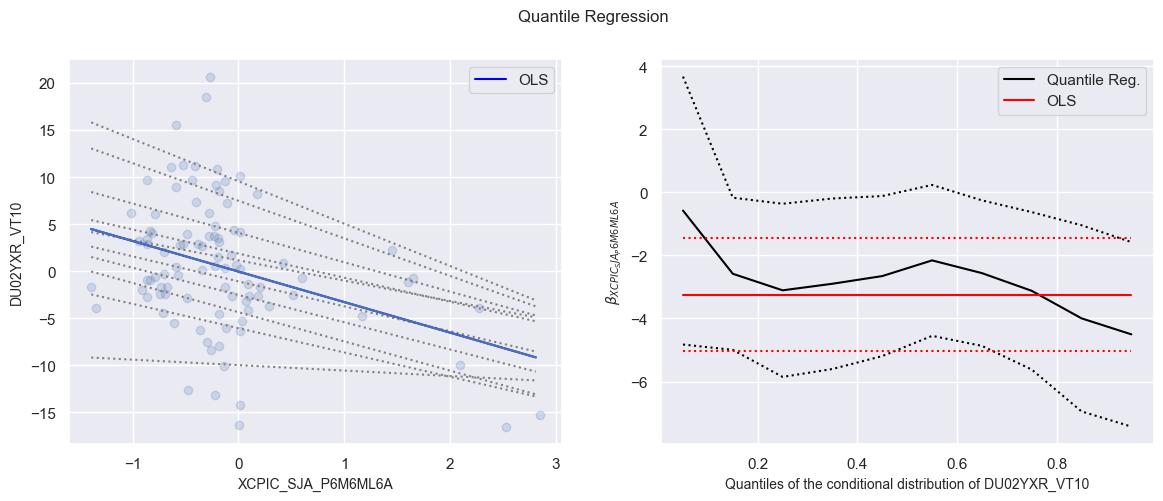

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.set(rc={"figure.figsize": (15, 3)})

fig.suptitle("Quantile Regression", fontsize=12)

minx = np.min(dfw.XCPIC_SJA_P6M6ML6AR)
maxx = np.max(dfw.XCPIC_SJA_P6M6ML6AR)
x = np.arange(minx, maxx, 0.1)

get_y = lambda a, b: a + b * x


for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax1.plot(x, y, linestyle="dotted", color="grey")
y = get_y(ols["a"], ols["b"])

sns.set_style("darkgrid")

ax1.plot(x, y, color="blue", label="OLS")
ax1.scatter(dfw.XCPIC_SJA_P6M6ML6AR, dfw.DU02YXR_VT10, alpha=0.2)

legend = ax1.legend()
ax1.set_xlabel("XCPIC_SJA_P6M6ML6A", fontsize=10)
ax1.set_ylabel("DU02YXR_VT10", fontsize=10)

ax1.plot(x, y)

n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{XCPIC_SJA_P6M6ML6A}$", fontsize=10)
plt.xlabel("Quantiles of the conditional distribution of DU02YXR_VT10", fontsize=10)
plt.legend()
plt.show()

## Rolling and recursive OLS Regression

**Rolling OLS** applies OLS across a fixed window of observations and then rolls (moves or slides) the window across the data set. __Recursive **least squares** apply OLS over expanding windows. Other steps and interpretations of rolling or recursive regressions are very similar to the above-described simple OLS regression. In the context of quantamental trading strategies these methods can serve two purposes:

* First, we can investigate the stability of relations. As economies are subject to structural change, a long-standing relation may be less promising as a future predictor if it has decayed in recent years.

* Second, we can adjust coefficients over time based on rolling or expanding lookback windows. This makes sense if relations are naturally time-varying but autocorrelated and we have no good explanatory variable to explain the time variation.

Both rolling and recursive OLS Regressions are implemented in Statsmodels and are based on this article [R Brown, J Durbin, J Evans](https://hhstokes.people.uic.edu/ftp/e535/Brown_Durbin_evans_1975.pdf).

Performing a rolling OLS regression of quarterly IRS returns on past excess inflation in the U.S. based on rolling 5-year windows is a useful approach to analyze the time-varying relationship between these variables. Below is an example code snippet that demonstrates how to perform such a regression using the statsmodels library and visualize the coefficient plot. The `statsmodels` class `regression.rolling.RollingOLS` manages rolling regressions. The coefficient plot suggests that OLS did not discover a significant relation in the 2000s and 2010s, but only in the 2020s.

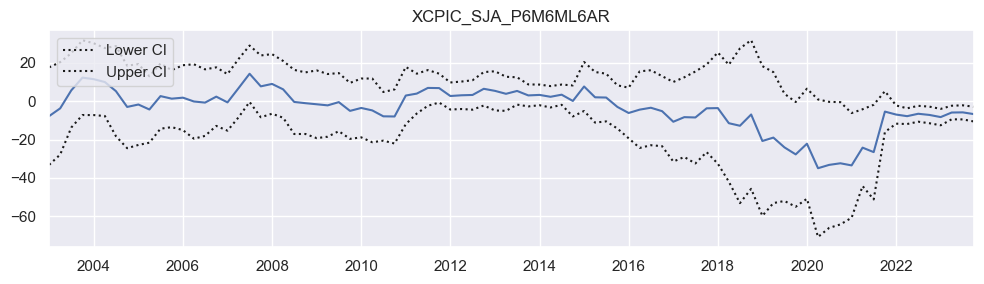

In [93]:
# Lagged quarterly features frame

dfw_feats = dfx_feats.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_feats = dfw_feats.resample("Q").last().reset_index().shift().dropna()
dfw_feats.set_index("real_date", inplace=True)

# Quarterly targets frame

dfw_targs = dfx_target.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_targs = dfw_targs.resample("Q").sum().reset_index()
dfw_targs.set_index("real_date", inplace=True)

# Run rolling regression
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # constant must be added
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10"]

mod = RollingOLS(y, X, window=3 * 4)  # 3 years lookback period

res = mod.fit()

fig = res.plot_recursive_coefficient(variables=['XCPIC_SJA_P6M6ML6AR'], figsize=(10, 3))

Recursive Least Squares (RLS) method is a variant of ordinary least squares (OLS) that corresponds to an expanding window approach. In RLS, the data set used for estimation is gradually expanded, and it assumes that past data never becomes obsolete. This method allows for ongoing updates of the estimated coefficients as new data becomes available.

However, there are some drawbacks to the expanding window approach. In the initial estimation periods, when the window is short, the coefficient estimates may be more sensitive to outliers or noise in the data. This can lead to less reliable estimates during the early stages of the regression.

Another drawback is the choice of the window size. The window size determines the number of observations used in each estimation, and it heavily influences the behavior of the estimates over time. Selecting an appropriate window size is a challenge and can be subjective. Fundamental arguments, such as the length of the business cycle, can guide the choice of window size, but it remains an arbitrary process to some extent.

Additionally, when the data is not sufficiently long, the use of a fixed window size prevents researchers from obtaining parameter estimates for the entire observation period. This limitation can be a drawback when analyzing macroeconomic data, where capturing long-term trends and relationships is often of interest.

In summary, while RLS provides a way to continuously update coefficient estimates as new data become available, the choice of window size and the limitations on obtaining estimates for the entire observation period are important considerations in the application of this method.

One way to estimate time-varying coefficients which do not require any arbitrary window size choice is a penalized regression spline approach. An example of using this approach for macroeconomic data analysis can be found in L [L Zanin and G Marra](https://www.researchgate.net/profile/Luca-Zanin-3/publication/227371633_Rolling_Regression_versus_Time-Varying_Coefficient_Modelling_An_Empirical_Investigation_of_the_Okun's_Law_in_Some_Euro_Area_Countries/links/5a81b1dfa6fdcc6f3ead5659/Rolling-Regression-versus-Time-Varying-Coefficient-Modelling-An-Empirical-Investigation-of-the-Okuns-Law-in-Some-Euro-Area-Countries.pdf).



In [94]:
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # constant must be added
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10"]

mod_rec = sm.RecursiveLS(y, X)
res_rec = mod_rec.fit()

Text(0.5, 0.98, 'Recursive coefficient')

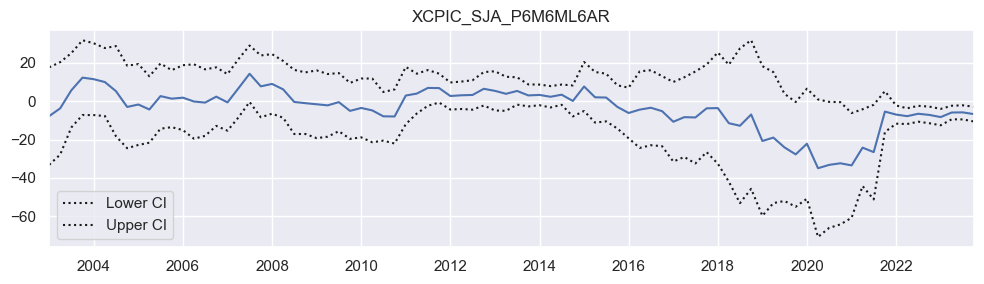

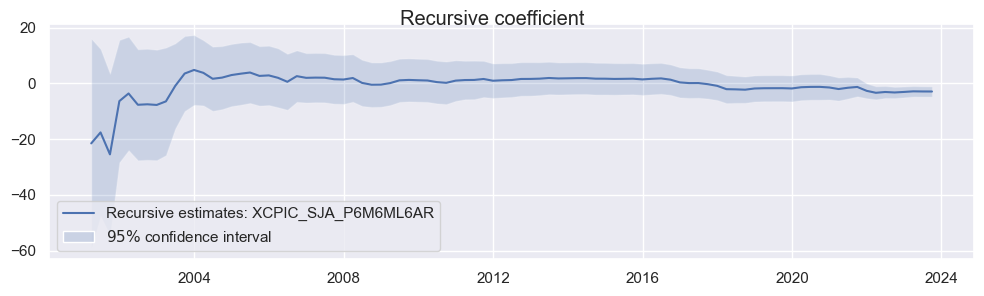

In [95]:
sns.set_style("darkgrid")

fig1 = res.plot_recursive_coefficient(
    variables="XCPIC_SJA_P6M6ML6AR", figsize=(10, 3), legend_loc="lower left"
)


fig2 = res_rec.plot_recursive_coefficient(
    range(mod_rec.k_exog)[0], figsize=(10, 3), legend_loc="lower left"
)
fig2.suptitle("Recursive coefficient", horizontalalignment="center", fontsize="large")

The CUSUM (Cumulative Sum) and CUSUM of squares tests are commonly used to detect structural changes or breakpoints in regression models. They are based on the methodology proposed by [Brown, Durbin and Evans](https://hhstokes.people.uic.edu/ftp/e535/Brown_Durbin_evans_1975.pdf). 
The CUSUM test examines whether the coefficients of an OLS regression model change as the sample size expands. It calculates a sequence of cumulative sums of recursive residuals (standardized one-step-ahead forecast errors) computed iteratively from nested subsamples of the data. The idea is that under the null hypothesis of coefficient constancy, these sums should stay within an expected range. If the cumulative sums deviate significantly from the expected range, it suggests a structural change in the model over time.

The CUSUM of squares test is a modification of the CUSUM test that considers the sum of squared recursive residuals instead of the raw residuals. This test is often preferred when the error terms are heteroscedastic (vary in variance over time).

Both tests provide a way to formally assess whether there is evidence of a structural change in the regression model. If the test statistics exceed critical values, it indicates that a structural change has likely occurred.

The charts below show the cumulative sums of recursive residuals for the two tests relative to the 5% confidence intervals. 
* If coefficients are stable cumulative sums of forecast errors should not drift much to one side. Hence, they are plotted against standard significance barriers for rejecting the null hypothesis of no structural break.
* Similarly, if OLS coefficients are stable in an expanding sample, the cumulative squares of the forecast residuals should grow linearly. 

The tests calculate recursive residuals (defined to be uncorrelated with zero means and constant variance) and the cumulative sums of those (in the first test) or squares of recursive residuals (second test) with 5% confidence intervals. The tests complement each other: they detect different instability patterns.

If CUSUM and CUSUM of squares statistic does not move outside of the 5% significance bands, we can not reject the null hypothesis of stable parameters at the 5% level. In our case, both plots show that the lines are well within the 5% significance bounds, which is a desired result, which is consistent with the hypothesis of stability over time. 

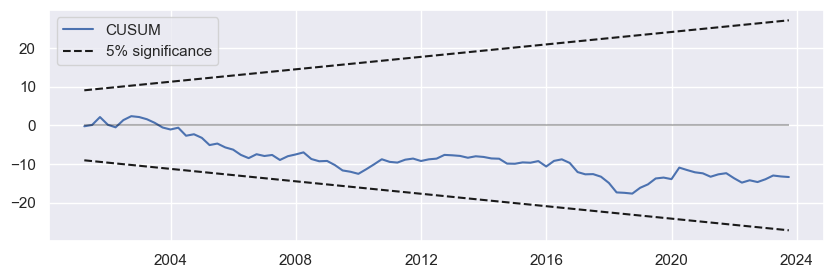

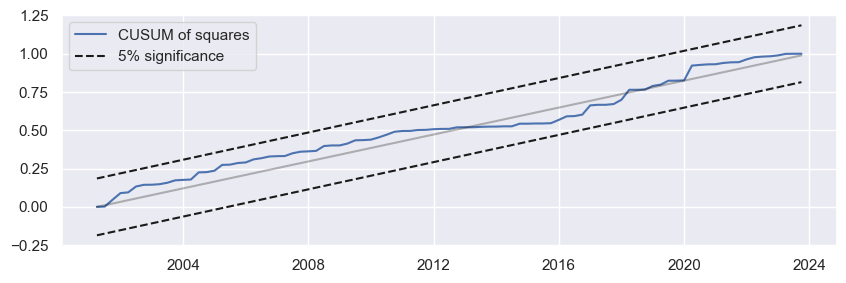

In [96]:
fig1 = res_rec.plot_cusum(figsize=(10, 3))
fig2 = res_rec.plot_cusum_squares(figsize=(10, 3))



## Regularised regression

Regularization is a technique used in regression to impose constraints on the flexibility of a model, with the goal of reducing uncertainty in the estimated parameter values. By penalizing model flexibility, regularization helps manage the tradeoff between bias and variance, mitigating the risk of overfitting. 

In the context of regression, regularization involves shrinking the coefficient estimates toward zero. This discourages the model from learning complex or flexible patterns that may be driven by noise in the data. By reducing the magnitude of the coefficients, regularization helps prioritize the most relevant variables and avoids overemphasizing less informative ones. [Gupta](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a). Theoretical justification, algorithms, and ideas behind the regularised regression formula in the `statsmodels` package can be found [here](https://www.jstatsoft.org/article/view/v033i01).

In the quantamental context, regularization is particularly important due to the correlation between economic trends and the relatively short time series data available. When there is no clear theoretical guidance on which indicators to use for prediction, regularization offers an objective criterion for variable selection. It penalizes the size of coefficients linearly, shrinking the coefficients of less relevant explanatory variables toward zero.

In `statsmodel`, the regularization of OLS regressions is implemented by applying the `fit_regularized()` method to a linear OLS model. The default type is effectively a LASSO (Least Absolute Shrinkage and Selection Operator), i.e. an elastic net estimator with a weight of 1 of the L1 penalty.  

In the provided example, regularization is applied to select the most predictive inflation trend series among six alternatives. The code calculates the parameters for excess inflation using regularization, allowing for the identification of the inflation series with the strongest historical predictive power.

In [97]:
feats = [
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
]  # categories (building blocks) for feature calculation


targs = [
    "DU02YXR_VT10",
]  # target returns


start_date = "2002-01-01"  # earliest sample date


dfx_feats_reg = msm.reduce_df(df, feats, cids, start=start_date)
dfx_target_reg = msm.reduce_df(df, targs, cids, start=start_date)

# Lagged monthly features frame

dfw_feats = dfx_feats_reg.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_feats = dfw_feats.resample("Q").last().reset_index().shift().dropna()
dfw_feats.set_index("real_date", inplace=True)

# Monthly targets frame

dfw_targs = dfx_target_reg.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_targs = dfw_targs.resample("Q").sum().reset_index()
dfw_targs.set_index("real_date", inplace=True)

An important parameter in the `fit_regularized` method is `alpha`, the penalty weight applied to each coefficient. The `alpha` parameter controls the penalty weight applied to each coefficient in the regularization process. A higher value of 'alpha' leads to more aggressive shrinkage of the coefficient estimates towards zero. When `alpha` is set to 0, the regularization becomes ineffective, and the `fit_regularized()` method reduces to a simple OLS regression. On the other hand, when `alpha` is set to a large value, the regularization becomes stronger, and it is possible for all coefficients to be effectively shrunk to zero, resulting in a sparse model.

`L1_wt` parameter, which determines the balance between L1 (LASSO) and L2 (Ridge) regularization. When `L1_w`t is set to 0, the fit corresponds to a Ridge regression, which only applies L2 regularization. When `L1_wt` is set to 1, the fit corresponds to a LASSO regression, which only applies L1 regularization. By setting `L1_wt` to a value between 0 and 1, such as 0.5, for example, the regularization becomes an elastic net regularization, combining both L1 and L2 penalties.

In [98]:
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # constant must be added
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10"]

lasso = sm.OLS(y, X).fit_regularized(method="elastic_net", alpha=0.1, L1_wt=1)

print(lasso.params)


CPIC_SA_P1M1ML12      0.000000
CPIC_SJA_P3M3ML3AR    0.000000
CPIC_SJA_P6M6ML6AR   -0.550353
CPIH_SA_P1M1ML12     -0.434065
CPIH_SJA_P3M3ML3AR   -0.387903
CPIH_SJA_P6M6ML6AR    0.000000
const                 3.052176
dtype: float64


## Logistic regression

Logistic regression is a statistical method commonly used for predicting the probability of a categorical outcome, particularly in binary classification problems. Unlike classical regression, which predicts continuous values, logistic regression focuses on estimating the probability of success or failure for a given outcome.

In logistic regression, the odds of success (probability of success divided by the probability of failure) are transformed using a logit function. This transformation, known as the log odds, allows for a linear combination of explanatory variables similar to ordinary least squares (OLS) regression.

In market and strategy applications, binary classification is often employed to predict whether the market will be "up or down" in the next period. In the example provided below, logistic regression is used to predict the probability of a 2-year swap return based on explanatory variables such as excess inflation, estimated excess GDP growth, and excess private credit growth. The data is collected at a monthly frequency.

Logistic regression is implemented through the `statsmodels.discrete.discrete_model.Logit` class. Logistic regression models are fitted using the maximum likelihood, choosing parameter values that maximize the likelihood of the observed data.

In [99]:
# Lagged monthly features frame

dfw_feats = dfx_feats.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_feats = dfw_feats.resample("M").last().reset_index().shift().dropna()
dfw_feats.set_index("real_date", inplace=True)

# Monthly target frame

dfw_targs = dfx_target.pivot(
    index=["real_date"], columns=["xcat"], values="value"
).dropna()
dfw_targs = dfw_targs.resample("M").sum().reset_index()
dfw_targs.set_index("real_date", inplace=True)

In [100]:
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # constant must be added
dfw_targs["DU02YXR_VT10_logit"] = np.where(
    dfw_targs["DU02YXR_VT10"] > 0, 1, 0
)  # convert returns to binary series
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10_logit"]

mod = sm.Logit(y, X)  # define model
logit_res = mod.fit()  # fit model
print(logit_res.summary())  # summary table

Optimization terminated successfully.
         Current function value: 0.663856
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:     DU02YXR_VT10_logit   No. Observations:                  287
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                            3
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                 0.03983
Time:                        20:26:50   Log-Likelihood:                -190.53
converged:                       True   LL-Null:                       -198.43
Covariance Type:            nonrobust   LLR p-value:                  0.001243
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
XCPIC_SJA_P6M6ML6AR           -0.4625      0.182     -2.547      0.011      

The output summary of a logistic regression model shares similarities with OLS regression, but there are important differences to consider:

In logistic regression, the coefficient does not represent the sensitivity of the dependent variable (probability) with respect to the explanatory variable. Instead, it reflects the sensitivity of the odds ratio, which is the ratio of the probability of a positive outcome divided by the probability of a negative outcome, with respect to the odds ratio. This highlights the non-linear relationship between the explanatory variable and the probability, where the impact tends to decline at extreme values. The significance of the coefficients in logistic regression relates to their ability to predict the direction of the outcome variable rather than its scale.

The pseudo R-squared, unlike OLS R-squared, "does not represent the proportion of explained variance but rather the improvement in model likelihood over a null model...Almost all pseudo-R2s are influenced to some extent by sample size, number of predictor variables, and number of categories of the dependent variable and its distribution asymmetry." [Hemmert, Schons, and Schimmelpfennig](https://journals.sagepub.com/doi/abs/10.1177/0049124116638107?journalCode=smra). 

The likelihood ratio measures the relative merits of two hypotheses; a likelihood ratio of x means that the hypothesized predictive power of the explanatory variables is x times as likely, given the data, than the hypothesis of no predictive power (null hypothesis). Conversely, the p-value gives the probability of no predictive power of the model.

For a logistic regression model, the `.pred_table` method returns the confusion matrix (as `numpy` array) of classification based on the classification of the regression. The confusion matrix gives the predicted classification (positive/ not-positive) in the columns and the actual classification in the rows. The top-left number gives the number of correctly predicted positive returns. The confusion matrix is most useful as a basis for classification success ratios, such as accuracy.

![Confusion matrix](https://ars.els-cdn.com/content/image/3-s2.0-B9780323911979000138-f14-09-9780323911979.jpg)

In [101]:
cm = logit_res.pred_table()
print(cm)

[[ 56.  79.]
 [ 39. 113.]]


## Probit regression

Probit regression is another method used for estimating the probability of a binary outcome, similar to logit regression. While logit regression is based on the logistic function, probit regression uses a cumulative normal distribution to calculate the probability of a data point belonging to one of two categories.

In probit regression, the coefficients can be interpreted as the change in the z-score of the cumulative probability per unit change in the explanatory variable. This means that the impact of the explanatory variable on the probability is more pronounced near the mean of the distribution, where the probability changes are larger. As the data moves towards the tails of the distribution, the changes in probability become smaller.

Similar to logistic regression, probit regression can be used to predict whether a future trading period will result in a positive return. However, probit regression is often considered to be less intuitive in interpretation compared to logit regression. It is typically preferred when there is a belief that the binary outcome is governed by a normal distribution, which is commonly assumed for financial market returns.
In `statsmodels` probit is implemented with the `discrete.discrete_model.Probit` class.

In [102]:
X = dfw_feats
X = sm.add_constant(X, prepend=False)  # constant must be added
dfw_targs["DU02YXR_VT10_logit"] = np.where(dfw_targs["DU02YXR_VT10"] > 0, 1, 0)
y = dfw_targs.loc[dfw_feats.index, "DU02YXR_VT10_logit"]


mod = sm.Probit(y, X)
probit_res = mod.fit()
print(probit_res.summary())

Optimization terminated successfully.
         Current function value: 0.663805
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:     DU02YXR_VT10_logit   No. Observations:                  287
Model:                         Probit   Df Residuals:                      283
Method:                           MLE   Df Model:                            3
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                 0.03990
Time:                        20:26:50   Log-Likelihood:                -190.51
converged:                       True   LL-Null:                       -198.43
Covariance Type:            nonrobust   LLR p-value:                  0.001226
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
XCPIC_SJA_P6M6ML6AR           -0.2873      0.110     -2.616      0.009      

The confusion matrix is typically very similar to logit regression's confusion matrix.

In [103]:
cm = probit_res.pred_table()
print(cm)

[[ 55.  80.]
 [ 39. 113.]]


# Time series analysis of quantamental indicators

## Autocorrelation analysis

Autocorrelation analysis is a valuable tool in the exploratory data analysis of time series forecasting. It helps detect patterns and assess the degree of randomness in the data.
In the context of **quantamental** indicators autocorrelation analysis provides insights into the strength or persistence of the signal contained within the data. By examining the autocorrelation of the indicators, we can understand how the past values of the series relate to the current and future values.

In the provided example, monthly data is used, and two types of indicators are showcased: those with strong autocorrelation (such as 6-month inflation) and those with almost no autocorrelation (such as duration returns).

The plots on the left-hand side depict the usual autocorrelation plots, which show the correlation between a time series and its lagged values over a specified number of time steps. These plots help identify any significant patterns or trends in the autocorrelation.

The plots on the right-hand side display partial autocorrelation plots, which summarize the relationship between a variable in a time series and its past observations while accounting for the influence of intervening observations. These plots provide a clearer picture of the direct relationship between the variable and its lagged values.

By examining both the autocorrelation and partial autocorrelation plots, we can gain insights into the temporal dynamics and potential predictability of the quantamental indicators.

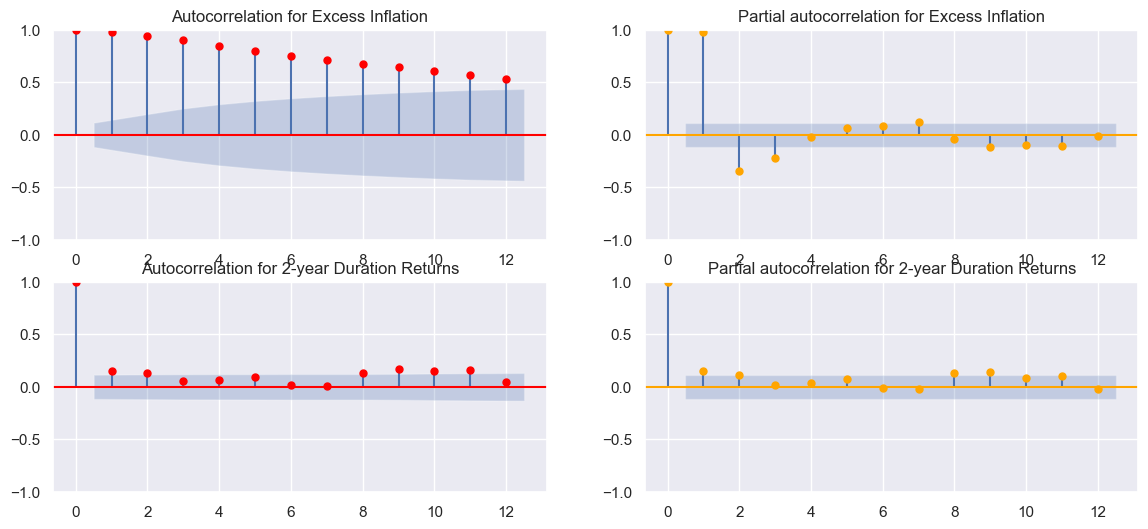

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
sm.graphics.tsa.plot_acf(
    dfw_feats.XCPIC_SJA_P6M6ML6AR.squeeze(), color="red", lags=12, ax=ax[0, 0]
)

ax[0, 0].set_title("Autocorrelation for Excess Inflation")
sm.graphics.tsa.plot_pacf(
    dfw_feats.XCPIC_SJA_P6M6ML6AR.squeeze(), color="orange", lags=12, ax=ax[0, 1]
)

ax[0, 1].set_title("Partial autocorrelation for Excess Inflation")

sm.graphics.tsa.plot_acf(
    dfw_targs.DU02YXR_NSA.squeeze(), color="red", lags=12, ax=ax[1, 0]
)

ax[1, 0].set_title("Autocorrelation for 2-year Duration Returns")
sm.graphics.tsa.plot_pacf(
    dfw_targs.DU02YXR_NSA.squeeze(), color="orange", lags=12, ax=ax[1, 1]
)
ax[1, 1].set_title("Partial autocorrelation for 2-year Duration Returns")
plt.show()

The high autocorrelation observed in the monthly CPI values (left-hand plot above) confirms the general economic theory that changes in CPI tend to exhibit persistence or trend from one month to the next. The fact that the current CPI value is highly correlated with the immediate past value indicates a potential momentum or persistence in inflation trends. This finding aligns with the notion that inflation is influenced by various factors, including price stickiness, market dynamics, and economic conditions. These factors can lead to a gradual adjustment of prices over time, resulting in a certain degree of autocorrelation in CPI values. The high autocorrelation suggests that the recent values of CPI can provide useful information for predicting future inflation trends. 

By recognizing and understanding the autocorrelation patterns in CPI values, economists and policymakers can gain insights into the dynamics of inflation and make informed decisions regarding monetary policy, fiscal measures, and economic forecasting.

On the other hand, duration returns, are not expected to exhibit strong autocorrelation. Duration returns are influenced by a variety of factors, such as interest rate movements, market conditions, and economic factors, which can lead to more random or unpredictable behavior. Therefore, it's expected to see low autocorrelation in duration returns, as shown in the right-hand plot.  

## Exponential smoothing

Exponential smoothing is indeed a valuable technique for discerning trends in noisy data and capturing the underlying patterns. The idea is to use a moving average that gives higher weights to more recent values and assigns gradually decreasing weights to older measured values. The numeric value (smoothing parameter), ${\alpha}$ is set between 0 and 1 and controls the decay of weights into the past. A smaller value (closer to 0) creates a smoother (slowly changing) line similar to a moving average with a large number of periods. A high value for `alpha` tracks the data more closely by giving more weight to recent data. It creates a more jagged line because they weigh current data more highly, which reduces the degree of averaging by the older data. In the extreme case of ${\alpha}$ = 1, the resulting time series is equivalent to the actual time series. The choice of the smoothing parameter ${\alpha}$ depends on the desired trade-off between responsiveness to recent data and the level of smoothing. In the example below we picked 2 values of  ${\alpha}$ to demonstrate the effect. 

The half-life ${\tau}$ can be used interchangeably with ${\alpha}$. The half-life ${\tau}$ represents the number of recent periods that contain half of the total weights of the smoothing average, providing an intuitive measure of the time-span considered in the smoothing process, providing an intuitive measure of the time-span considered in the smoothing process.

The relationship between ${\alpha}$ and ${\tau}$ is deterministic: 

$(1-{\alpha})^{\tau+1} = \frac{1}{2}$  

${\tau} = - \frac{ln 2}{ln (1-\alpha)}$  

Various forms of simple exponential smoothing are supported by the class `statsmodels.tsa.holtwinters.SimpleExpSmoothing`. 


This simple function calculates ${\tau}$ for each desired ${\alpha}$

In [105]:
def tau(alpha):
    tau = (-np.log(2) / np.log(1 - alpha)).round(4)
    return tau


alpha_003 = 0.03
alpha_013 = 0.13
print(
    "Example: tau for alpha = ",
    alpha_003,
    "the latest ",
    tau(alpha_003),
    "observations contain half of the weights for the current smoothened level",
)
print(
    "Example: tau for alpha = ",
    alpha_013,
    "the latest ",
    tau(alpha_013),
    "observations contain half of the weights for the current smoothened level",
)

Example: tau for alpha =  0.03 the latest  22.7566 observations contain half of the weights for the current smoothened level
Example: tau for alpha =  0.13 the latest  4.9773 observations contain half of the weights for the current smoothened level


In contrast to moving averages with fixed (but rolling estimation window), the lookback window used in exponential smoothing does not cut off, so the estimation is based on expanding windows. However, in practice, the importance of earlier observations is declining exponentially, in the example above with `alpha` being 0.13, half of the weights are used for just 5 last observations (for daily data - days). 

In the context of JPMaQS <u>exponential smoothing can be used as an estimate of sluggish or adaptive expected values</u>, rather than trends. Quantamental data always record the latest information state of the public with respect to an economic and financial concept at the end of a given day. In cases where no new information regarding the concept is released for an extended period, the value may remain unchanged over many days.

Thus quantamental indicators are representative of an attentive market participant. However, many agents in the economy or even in markets may not update themselves on economic states daily. Thus, the average public or market information state may be represented by an exponential moving average, where halftime denotes the time elapsed until half the population has caught up with the latest information state. Differences between the latest and sluggish information updates may indicate trading opportunities.

The below code runs three examples of simple exponential smoothing: 

1. In `ema003` we do not use any optimization based on data but instead choose to provide the model with the parameter $alpha$ = 0.03. This implies a half-time of around 23 days and means that the exponential moving average mimics a market where 50% of agents have updated their perception over the last 23 days (roughly once a month). Using the formula above ${\tau} = - \frac{ln 2}{ln (1-alpha)}$   $\approx$ 22.8, meaning that the last 22.8 observations contain half of the total weights of the smoothing average. 


2. In `ema013` as above we likewise choose the weight decay up front but with alpha = 0.13, which implies a half-time of roughly 5 working days (a week). 


3. In `emaop` we allow statsmodels to optimize the weight decay based on past data, minimizing the sum of squared errors of one-day ahead predictions. For economic data information states a case can be made to apply frequency conversion first, before applying this method, to get the published economic series in its native updating frequency rather than daily (often unchanging) values. But for simplicity, we start by applying the method to daily information states.

In `ema003` and `ema013` the argument `heuristic` refers to the choice of initial values; it is not based on a particular statistical principle but is using "a reasonable approach" that was found to often work well in practice. It is described in section 2.6.1 of Hyndman et al. (2008), ["Forecasting with Exponential Smoothing"](https://robjhyndman.com/expsmooth/expsmooth_ch2.pdf).

In [106]:
# Select cross-sections

cidx = ["USD", "EUR"]

# Select frame with required data

xcat_sel = "INTRGDPv5Y_NSA_P1M1ML12_3MMA"  # select category
start_date = "2002-01-01"

filt1 = df["xcat"] == xcat_sel  #  filter for category
filt2 = df["real_date"] >= pd.to_datetime(start_date)  # filter for start date
filt3 = df["cid"].isin(cidx)
dfx = df[filt1 & filt2 & filt3]  # filter out relevant data frame

# Compute ane estimate exponential moving averages

dfw = dfx.pivot_table(index="real_date", columns="cid", values="value").replace(
    0, np.nan
)  # wide time series df

dfema = pd.DataFrame(columns=["cid", "xcat", "real_date", "value"])

for cid in cidx:

    ema003 = SimpleExpSmoothing(
        dfw[cid].dropna(), initialization_method="heuristic"
    ).fit(smoothing_level=alpha_003, optimized=False)

    ema013 = SimpleExpSmoothing(
        dfw[cid].dropna(), initialization_method="heuristic"
    ).fit(smoothing_level=alpha_013, optimized=False)

    emaop = SimpleExpSmoothing(
        dfw[cid].dropna(), initialization_method="estimated"
    ).fit()

    df003 = ema003.fittedvalues.to_frame().reset_index().rename(columns={0: "value"})
    df003["xcat"] = xcat_sel + "_EMA003"

    df013 = ema013.fittedvalues.to_frame().reset_index().rename(columns={0: "value"})
    df013["xcat"] = xcat_sel + "_EMA013"

    dfop = emaop.fittedvalues.to_frame().reset_index().rename(columns={0: "value"})
    dfop["xcat"] = xcat_sel + "_EMAOP"
    Opt_alpha = emaop.params["smoothing_level"].round(4)

    dfc = pd.concat([df003, df013, dfop])

    dfc["cid"] = cid
    dfc = dfc[list(dfema.columns)]
    dfema = pd.concat([dfema, dfc])


dfx["xcat"] = xcat_sel
dfema = pd.concat([dfema, dfx[list(dfema.columns)]])


print(f"Optimized alpha since {start_date}", Opt_alpha)
print(
    "Tau is",
    tau(Opt_alpha),
    "days (using daily data) for Optimized alpha ",
    Opt_alpha,
)

Optimized alpha since 2002-01-01 0.8633
Tau is 0.3483 days (using daily data) for Optimized alpha  0.8633


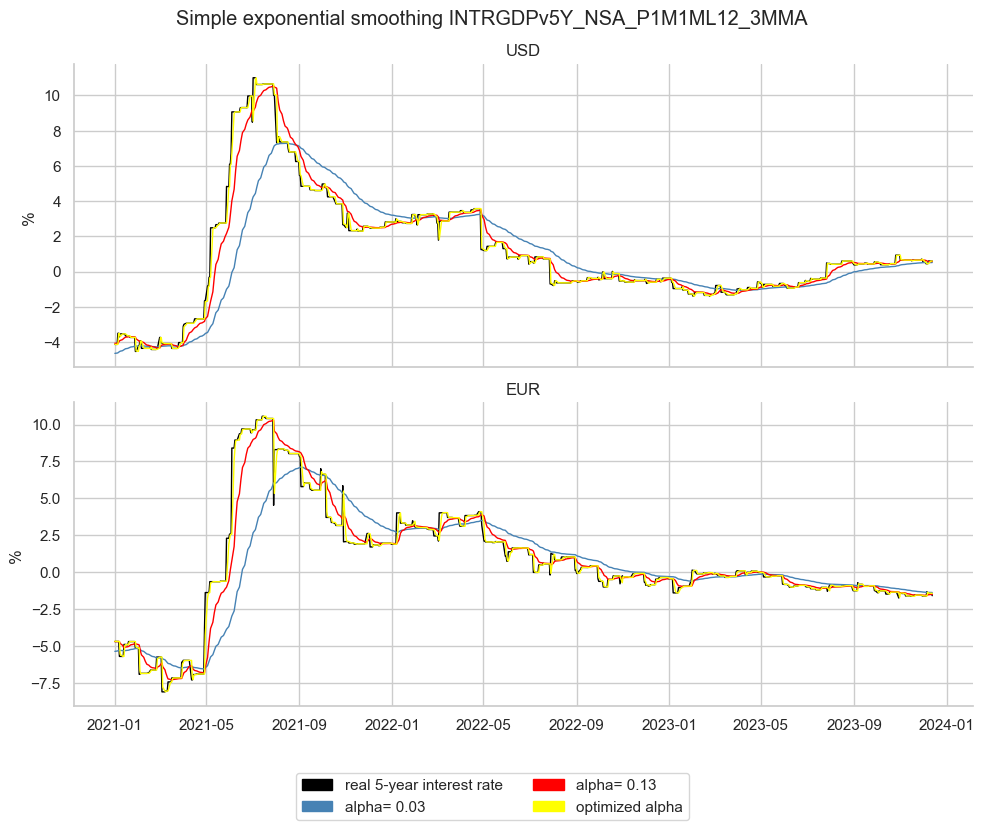

In [107]:
dfemx = dfema[dfema["real_date"] >= pd.to_datetime("2021-01-01")]

xcats_ema = [xcat_sel + x for x in ["", "_EMA003", "_EMA013", "_EMAOP"]]
colors = ["black", "steelblue", "red", "yellow"]  # choose color palette


sns.set_theme(style="whitegrid", palette=colors)  #  choose appearance
fg = sns.FacetGrid(
    dfemx,
    col="cid",
    col_wrap=1,  # set number of columns of the grid
    palette=colors,
    hue="xcat",
    hue_order=xcats_ema,
    height=4,
    aspect=2.5,  # set height and aspect ratio of cheach chart
    sharey=False,
)  # gives individual y axes to grid plots

fg.map_dataframe(
    sns.lineplot, x="real_date", y="value", ci=None, lw=1
)  # map lineplot to the grid

fg.set_axis_labels("", "% ")  # set axes labels of individual charts
fg.set_titles(col_template="{col_name}")  # set individual charts' title
fg.fig.suptitle(
    f"Simple exponential smoothing {xcat_sel}", y=1.02
)  # set facet grid title

name_to_color = {
    "real 5-year interest rate": colors[0],
    f"alpha= {alpha_003}": colors[1],
    f"alpha= {alpha_013}": colors[2],
    "optimized alpha": colors[3],
}

patches = [
    mpl.patches.Patch(color=v, label=k) for k, v in name_to_color.items()
]  # legend requires patch (due to bug)
labels = name_to_color.keys()  # series labels for legend box
fg.fig.legend(
    handles=patches, labels=labels, loc="lower center", ncol=2
)  # add legend to bottom of figure

fg.fig.subplots_adjust(bottom=0.15)  # lift bottom so it does not conflict with legend
plt.show()

Time series of chosen `alpha` (based on half time of roughly a week or a month in our example) is suitable for backtesting and it clearly smoothens the original data, thus getting rid of the "noise".  Optimized exponential moving averages calculate past smoothed values based on FUTURE information. Such time series are not information states and, hence, not suitable for backtesting. The correct way of calculating optimized exponential moving averages is to sequentially re-estimate the smoothing factor and calculate the averaged indicator at each point in time using the parameter that was optimal at that point in time. This is equivalent to the use of data vintages, i.e. time series of exponentially smoothed time series. A more realistic calculation in many cases (where daily data is available) would be to run the smoothing estimation for a daily dataframe, at month-end dates to estimate the optimal ${\alpha}$ at each month's end. We then apply optimized `alpha` to a time series of the end of NEXT month. Then we include the next month's section, again estimate new optimized ${\alpha}$ and apply to the following month's daily data:

In [108]:
filt1 = df["xcat"] == "EQXR_VT10"
filt2 = df["cid"] == "USD"
dfx = (
    df[filt1 & filt2].loc[:, ["real_date", "value"]].dropna().set_index("real_date")
).rename(
    columns={"value": "EQXR_VT10"}
)  # time series df
dfx.index = pd.to_datetime(dfx.index)
dfx = dfx[pd.Timestamp("2020-01-01") :]


np.diff(np.array(dfx.index.month))

month_end = list(np.diff(np.array(dfx.index.month)) != 0) + [True]

# check the

display(
    dfx.loc[
        month_end,
    ].index
)

# count how many month ends we have in the daily dataframe
count_month_end = sum(month_end)

DatetimeIndex(['2020-01-31', '2020-02-28', '2020-03-31', '2020-04-30',
               '2020-05-29', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31',
               '2021-01-29', '2021-02-26', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-30', '2021-08-31',
               '2021-09-30', '2021-10-29', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-30',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-28',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-29', '2023-10-31', '2023-11-30', '2023-12-13'],
              dtype='datetime64[ns]', name='real_date', freq=None)

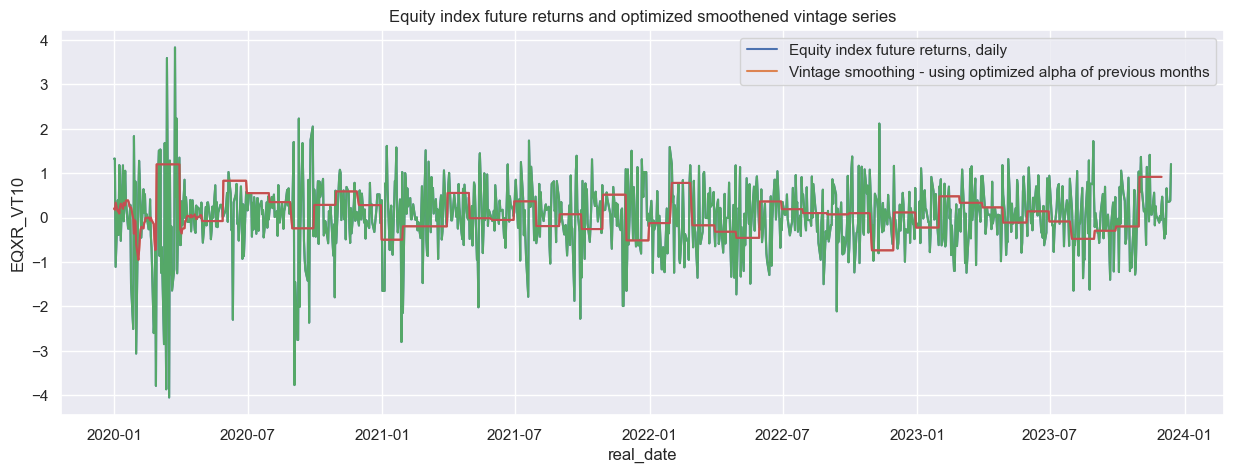

In [109]:
dfxo = dfx.copy().replace(to_replace=0, method="bfill")

# 1. define initial daily time frame until the end of second full month
dfema = dfx.loc[
    : dfx.loc[
        month_end,
    ].index[1]
]

# 2. apply optimized simple exp smoothing to the initial time frame
emaop = SimpleExpSmoothing(dfema.dropna(), initialization_method="estimated").fit()
Opt_alpha = emaop.params["smoothing_level"]

# 3. populate placeholder dataframe with new values
dfxo["smoothened_value"] = emaop.fittedvalues.to_frame()

# 4. Apply similar logic to the rest of data series using a loop:


for i in range(1, count_month_end - 1):
    dfema1 = dfxo["EQXR_VT10"].loc[
        dfx.loc[
            month_end,
        ]
        .index[i - 1] : dfx.loc[
            month_end,
        ]
        .index[i]
    ]

    emaop1 = SimpleExpSmoothing(dfema1, initialization_method="heuristic").fit(
        smoothing_level=Opt_alpha, optimized=False
    )

    dfop1 = emaop1.fittedvalues.to_frame()

    dfxo.loc[dfxo.index.isin(dfop1.index), ["smoothened_value"]] = dfop1[[0]].values

    dfema2 = dfxo["EQXR_VT10"].loc[
        : dfx.loc[
            month_end,
        ].index[i - 1]
    ]

    emaop1 = SimpleExpSmoothing(dfema2, initialization_method="estimated").fit()
    Opt_alpha = emaop1.params["smoothing_level"]


sns.set(rc={"figure.figsize": (15, 5)})

fig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    data=dfxo,
    x="real_date",
    y="EQXR_VT10",
    label="Equity index future returns, daily",
    ax=ax,
)
sns.lineplot(
    data=dfxo,
    x="real_date",
    y="smoothened_value",
    label="Vintage smoothing - using optimized alpha of previous months",
    ax=ax,
)
plt.title("Equity index future returns and optimized smoothened vintage series")

plt.plot(dfxo)

The reason for flat lines on the plot below is that Simple exponential smoothing has a “flat” forecast function. Thus, all forecasts take the same value, equal to the last level component. For details please see [here](https://otexts.com/fpp2/ses.html). If the time series has trend or seasonality patterns, more advanced methods like Holt's Linear Exponential Smoothing or Seasonal Exponential Smoothing should be considered.